<a href="https://colab.research.google.com/github/kshipra-jadav/ztm-dl/blob/master/Transfer_Learning_with_Tensorflow_(Part_3)_ZTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling Up (Food Vision mini)

## Getting the helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-13 04:23:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-13 04:23:31 (110 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Getting the dataset! (101 Food Classes!)

> The dataset downloaded has 101 food classes but only 10% of the training data

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-08-13 01:58:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  39.9MB/s    in 40s     

2023-08-13 01:58:40 (38.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
from helper_functions import unzip_data

unzip_data("101_food_classes_10_percent.zip")

In [4]:
base_dir = "101_food_classes_10_percent"
train_dir = f"{base_dir}/train"
test_dir = f"{base_dir}/test"

In [5]:
from helper_functions import walk_through_dir

walk_through_dir(base_dir)

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 250 ima

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data_10pc = image_dataset_from_directory(directory=train_dir,
                                               image_size=(224, 224),
                                               label_mode="categorical")
test_data_10pc = image_dataset_from_directory(directory=test_dir,
                                              image_size=(224, 224),
                                              label_mode="categorical",
                                              shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Training A Big Transfer Learning Model on 10% of 101 Food Classes
Here are the steps to be taken :-
1. Create a ModelCheckpoint callback
2. Create data augmentation layer
3. Build a headless (no top layers) functional EfficientNetB0 backboned model
4. Compile the model
5. Feature extract for 5 epochs

## Creating ModelCheckpoint Callback

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "101_classes_10_percent_checkpoints"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

## Creating Data Augmentation Layer

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomWidth, RandomTranslation, RandomBrightness, RandomCrop, RandomZoom, RandomHeight, RandomRotation, RandomFlip

data_augmentation = Sequential([
    RandomWidth(0.2),
    RandomHeight(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomRotation(0.2),
    RandomFlip("horizontal")
], name="data_aug_layer")

## Creating a headless functional EfficientNet B0 model

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name="global_avg")(x)
outputs = Dense(101, activation="softmax")(x)

model_1 = Model(inputs, outputs, name="model_1")

In [15]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug_layer (Sequential)  (None, None, None, 3)    0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg (GlobalAveragePo  (None, 1280)             0         
 oling2D)                                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

In [16]:
0.15 * len(test_data_10pc)

118.5

In [19]:
model_1.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

model_1_history = model_1.fit(train_data_10pc,
                              validation_data=test_data_10pc,
                              validation_steps = int(0.15 * len(test_data_10pc)),
                              epochs=5,
                              callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 104s 406ms/step - loss: 3.1640 - accuracy: 0.3092 - val_loss: 2.2256 - val_accuracy: 0.4899
Epoch 2/5
237/237 [==============================] - 78s 325ms/step - loss: 2.2089 - accuracy: 0.4932 - val_loss: 1.8387 - val_accuracy: 0.5448
Epoch 3/5
237/237 [==============================] - 68s 287ms/step - loss: 1.8978 - accuracy: 0.5460 - val_loss: 1.6896 - val_accuracy: 0.5704
Epoch 4/5
237/237 [==============================] - 62s 258ms/step - loss: 1.6922 - accuracy: 0.5860 - val_loss: 1.6315 - val_accuracy: 0.5752
Epoch 5/5
237/237 [==============================] - 56s 234ms/step - loss: 1.5368 - accuracy: 0.6279 - val_loss: 1.5827 - val_accuracy: 0.5781


In [20]:
model_1.evaluate(test_data_10pc)

790/790 [==============================] - 63s 79ms/step - loss: 1.5891 - accuracy: 0.5807


[1.5891075134277344, 0.5806732773780823]

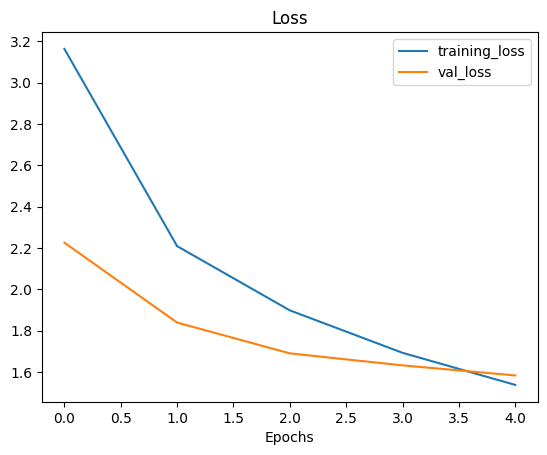

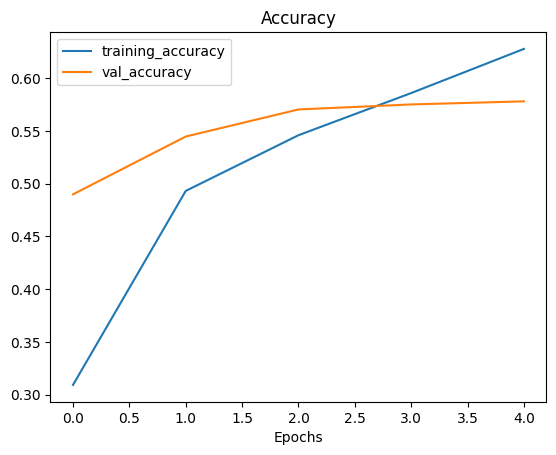

In [21]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_1_history)

## Fine Tuning Previous Model By Unfreezing Some Layers

In [31]:
from tensorflow.keras.models import clone_model

model_2 = clone_model(model_1)

model_2.set_weights(model_1.get_weights())

In [32]:
model_2.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

model_2.evaluate(test_data_10pc)

790/790 [==============================] - 64s 76ms/step - loss: 1.5891 - accuracy: 0.5807


[1.589107632637024, 0.5806732773780823]

In [30]:
model_2.layers[2].trainable = True

for layer in model_2.layers[2].layers[:-5]:
  layer.trainable = False

for layer_num, layer in enumerate(model_2.layers[2].layers):
  print(layer_num, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [34]:
from tensorflow.keras.optimizers import Adam

model_2.compile(optimizer=Adam(learning_rate=0.0001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

model_2_history = model_2.fit(train_data_10pc,
                              validation_data=test_data_10pc,
                              validation_steps=int(0.15 * len(test_data_10pc)),
                              epochs=len(model_1_history.epoch) + 5,
                              initial_epoch=model_1_history.epoch[-1],
                              callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 64s 238ms/step - loss: 1.3955 - accuracy: 0.6602 - val_loss: 1.5549 - val_accuracy: 0.5879
Epoch 6/10
237/237 [==============================] - 52s 219ms/step - loss: 1.3846 - accuracy: 0.6627 - val_loss: 1.5536 - val_accuracy: 0.5919
Epoch 7/10
237/237 [==============================] - 51s 212ms/step - loss: 1.3549 - accuracy: 0.6723 - val_loss: 1.5410 - val_accuracy: 0.5940
Epoch 8/10
237/237 [==============================] - 49s 203ms/step - loss: 1.3422 - accuracy: 0.6731 - val_loss: 1.5392 - val_accuracy: 0.5945
Epoch 9/10
237/237 [==============================] - 47s 198ms/step - loss: 1.3363 - accuracy: 0.6845 - val_loss: 1.5362 - val_accuracy: 0.5967
Epoch 10/10
237/237 [==============================] - 47s 197ms/step - loss: 1.3246 - accuracy: 0.6771 - val_loss: 1.5311 - val_accuracy: 0.5969


In [35]:
model_2.evaluate(test_data_10pc)

790/790 [==============================] - 66s 83ms/step - loss: 1.5443 - accuracy: 0.5950


[1.544313907623291, 0.5949702858924866]

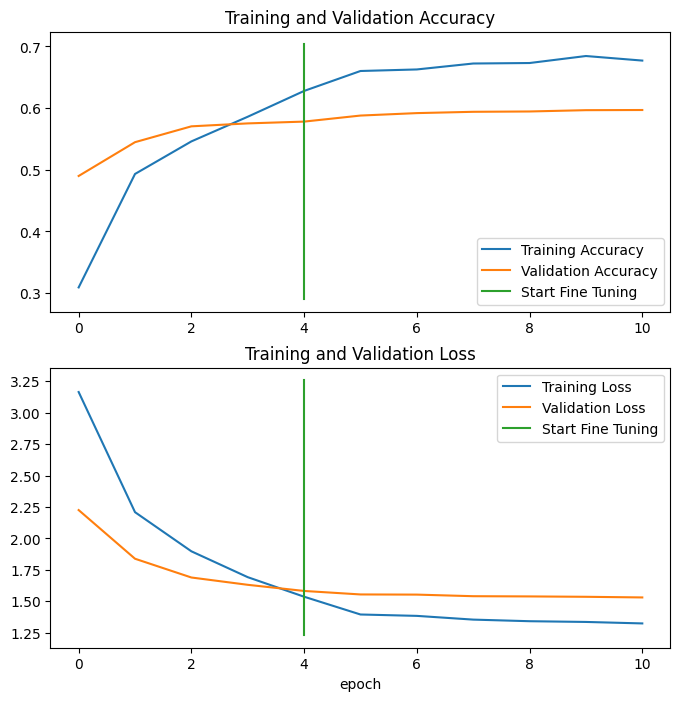

In [39]:
from helper_functions import compare_historys

compare_historys(model_1_history, model_2_history)

# Evaluating The Performance Of The Model Across All The Classes

> Let us evalute the model and figure out where the model is "most" wrong.

In [40]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-08-13 03:39:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  19.6MB/s    in 2.3s    

2023-08-13 03:39:47 (19.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [41]:
from helper_functions import unzip_data

unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [11]:
import tensorflow as tf

ext_model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

ext_model.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
______________________________________

In [12]:
ext_model.evaluate(test_data_10pc)

790/790 [==============================] - 78s 84ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making Predictions From External Model

In [13]:
preds_probs = ext_model.predict(test_data_10pc, verbose=1)

790/790 [==============================] - 73s 90ms/step


In [46]:
len(preds_probs)

25250

In [47]:
len(preds_probs[1])

101

In [48]:
preds_probs.shape

(25250, 101)

In [51]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.52296200e-01, 4.10489474e-06, 5.93561502e-08, 4.86580420e-09,
        9.47518674e-06, 1.76695451e-07, 2.34152451e-02, 1.00856754e-11,
        7.93083757e-02, 1.67212929e-05, 1.18348325e-04, 1.47744984e-07,
        3.75844334e-04, 5.45975567e-08, 1.10864664e-06, 1.79380538e-06,
        1.62546712e-04, 6.66014821e-05, 2.70225224e-03, 7.03054013e-07,
        2.43328582e-03, 5.60963745e-05, 3.04525252e-03, 1.45969409e-07,
        1.47296839e-06, 1.05941651e-10, 1.27633416e-06, 2.66077299e-10,
        3.35412011e-07, 2.77307099e-05, 7.60481441e-07, 1.21581287e-03,
        1.69590987e-06, 2.43655807e-11, 2.08731526e-05, 6.03549637e-08,
        1.83168318e-04, 3.80155361e-05, 1.85873942e-05, 1.35400260e-05,
        3.47203763e-06, 1.86407718e-07, 6.18623337e-04, 1.23661794e-05,
        3.38839747e-08, 1.50329186e-07, 3.04685557e-08, 4.76577079e-05,
        4.31111902e-09, 2.96321628e-06, 5.17440100e-08, 8.66997141e-08,
        6.07158690e-05, 3.59274709e-04, 1.52317348e-09, 2.414060

In [14]:
# Getting the pred classes of each label

pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10], len(pred_classes)

(array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0]), 25250)

In [8]:
y_labels = []

for images, labels in test_data_10pc.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10], len(y_labels)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 25250)

In [15]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_true=y_labels, y_pred=pred_classes)
cnf_matrix

array([[ 51,   1,  25, ...,   5,   0,  16],
       [  0, 173,   0, ...,   0,   0,   0],
       [  8,   2, 162, ...,   1,   0,   3],
       ...,
       [  1,   0,   5, ...,  82,   0,   0],
       [  0,   1,   0, ...,   0,  67,   0],
       [  2,   0,   0, ...,   2,   0, 175]])

In [36]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      figsize=(100, 100),
                      text_size=20)

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels,
                      y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [38]:
# Calculating f1 score and plotting it

clf_rpt_dict = classification_report(y_true=y_labels, y_pred=pred_classes, output_dict=True)

clf_rpt_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [56]:
f1_dict = dict()

for key, value in clf_rpt_dict.items():
  if key.isdigit():
    class_name = test_data_10pc.class_names[int(key)]
    f1_score = value["f1-score"]
    f1_dict[class_name] = f1_score

f1_dict

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [57]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

<Figure size 1500x1500 with 0 Axes>

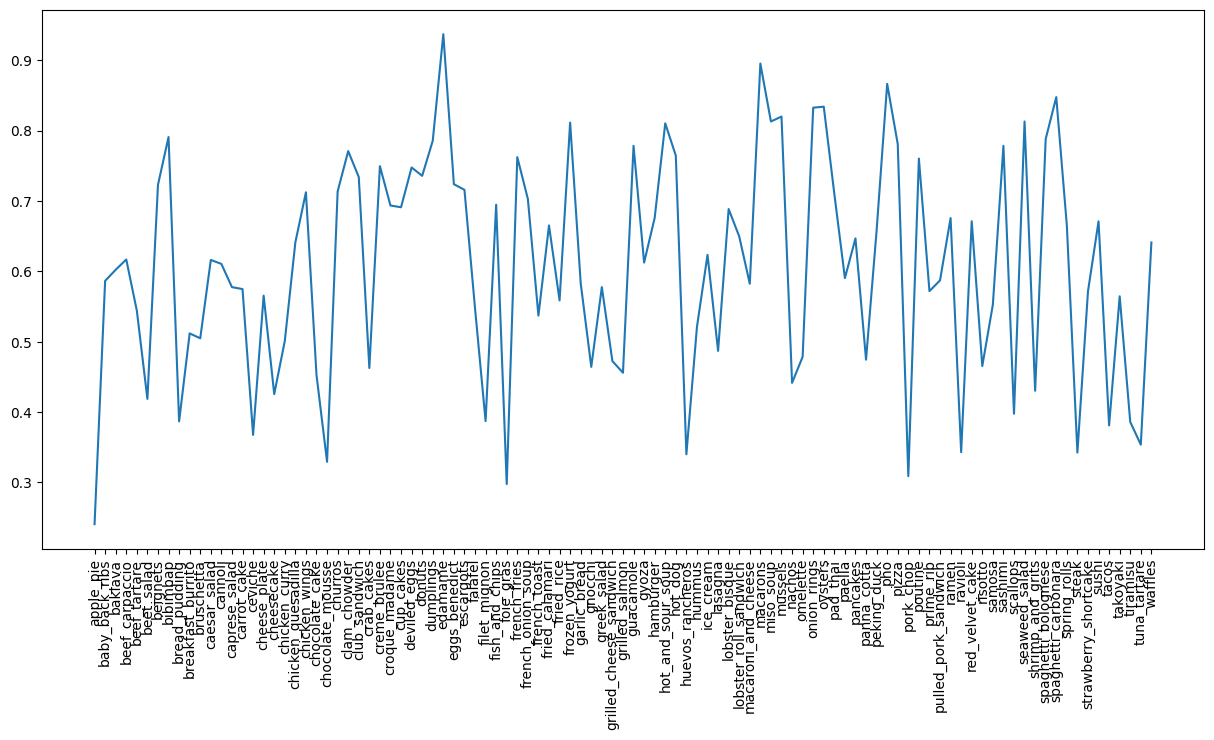

In [67]:
from matplotlib import pyplot as plt
x = f1_dict.keys()
y = f1_dict.values()
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(x, y)
plt.xticks(rotation=90)
plt.show()

In [70]:
import pandas as pd
df_data = {
    "class_name": f1_dict.keys(),
    "f1_score": f1_dict.values()
}

f1_scores = pd.DataFrame(df_data).sort_values("f1_score", ascending=False)

f1_scores.head()

class_name  f1_score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008

<Axes: xlabel='f1_score', ylabel='class_name'>

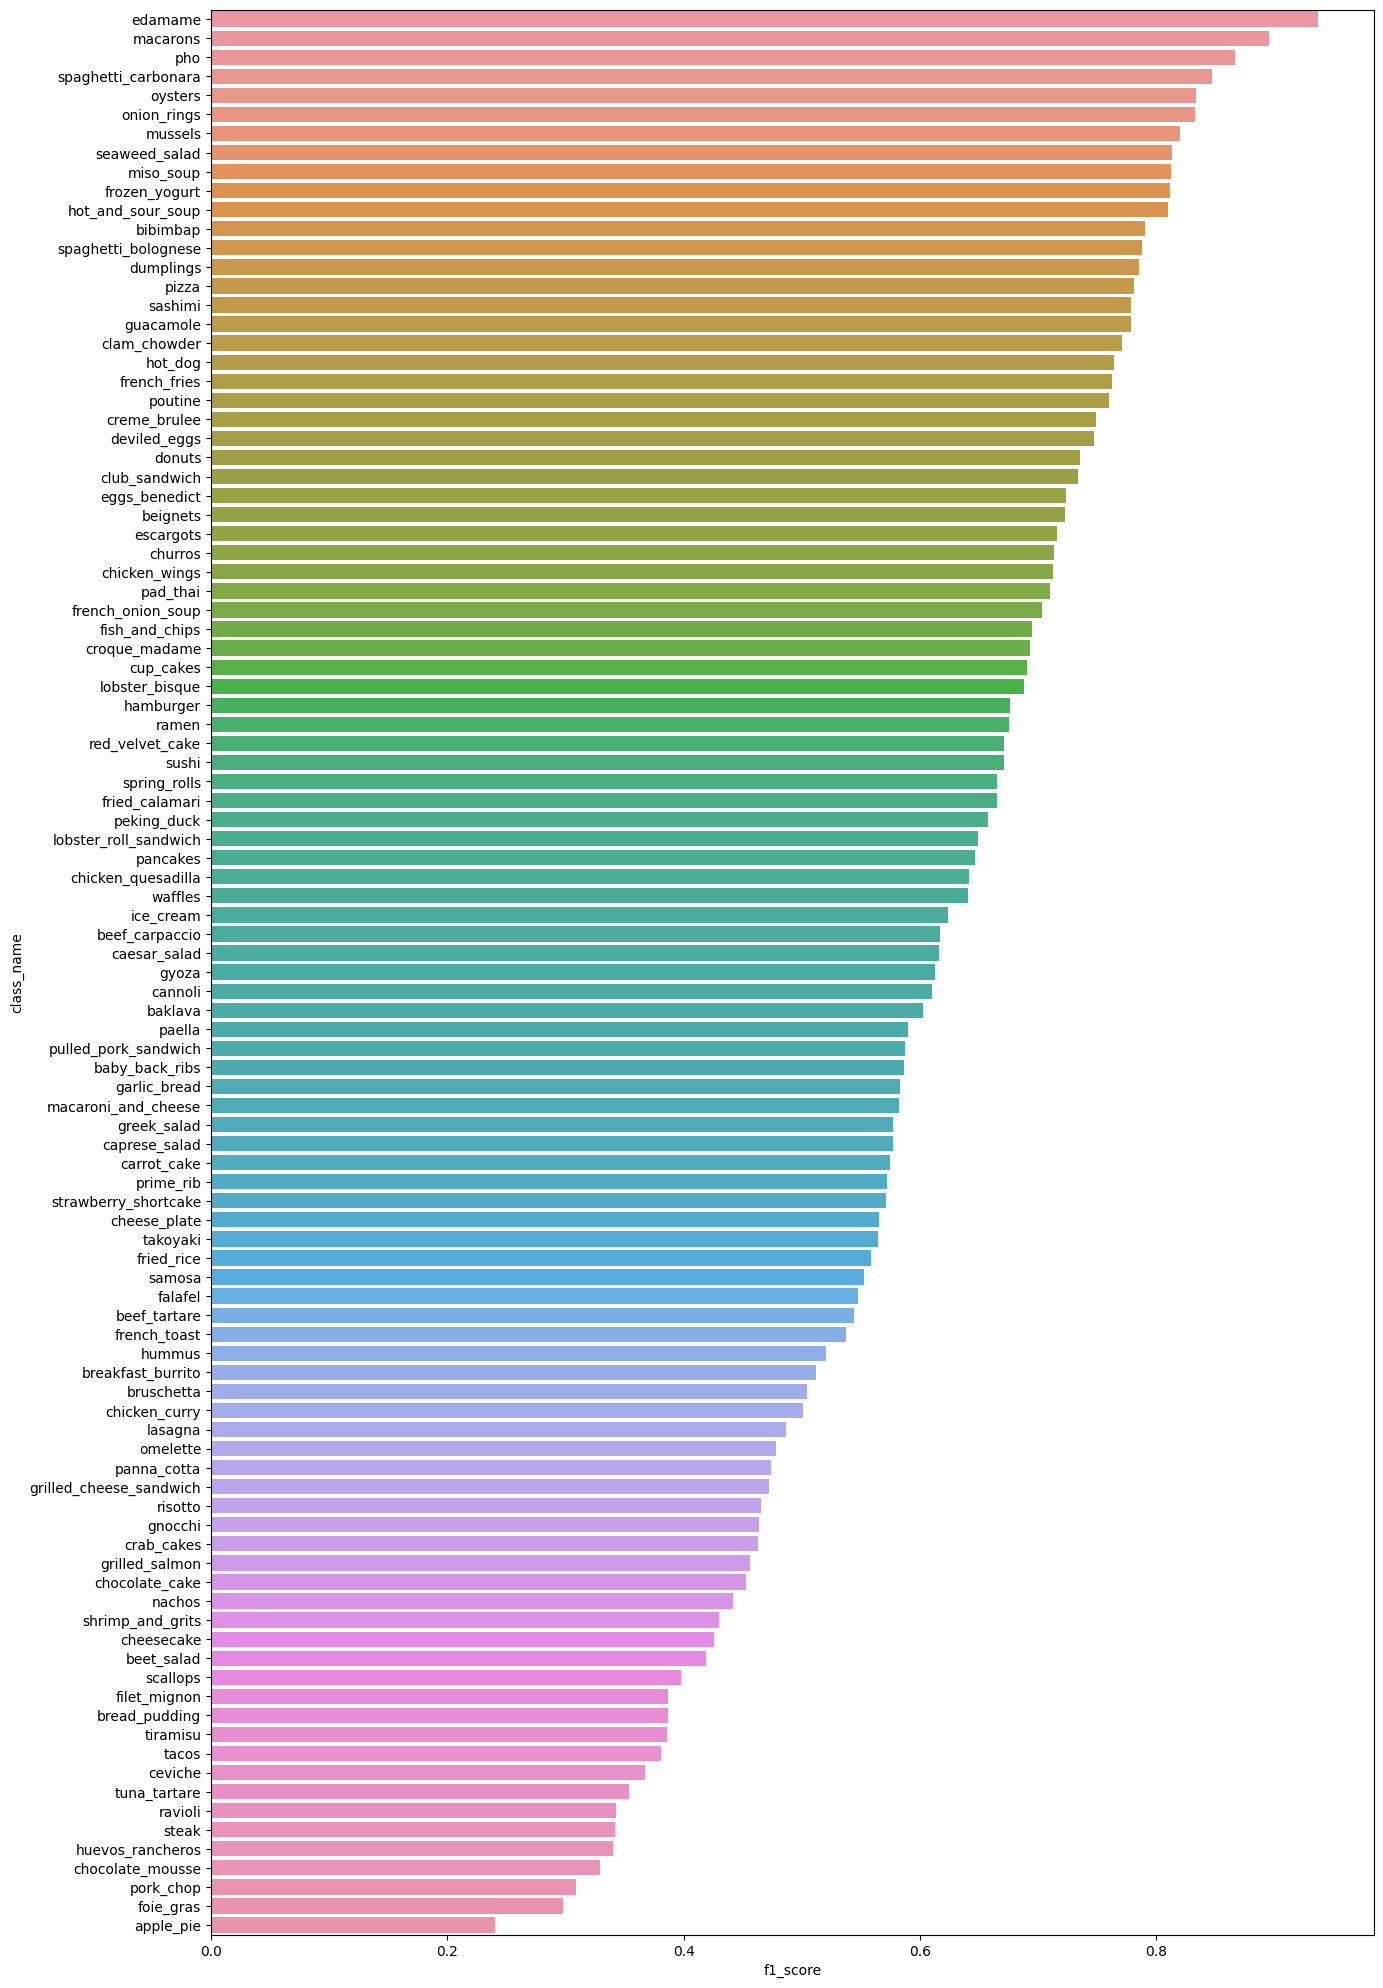

In [77]:
import seaborn as sns
plt.subplots(figsize=(15, 25))
sns.barplot(data=f1_scores, x="f1_score", y="class_name")